## K-Nearest Neighbors (KNN)

## About data

В качестве исходных данных используется набор, содержащий метрики отклика для 60 различных ультразвуковых частот. Каждый пример в наборе данных соответствует сигналу, направленному на один из двух классов объектов: «мина» или «камень». Целевой переменной является бинарная категория, определяющая тип объекта.

Количественные характеристики, полученные от сонара на 60 дискретных частотах, служат в качестве предикторов. Основной целью является создание прогностической модели, которая будет способна с высокой точностью классифицировать новые, ранее не виденные объекты на основе их акустических характеристик.

Источник данных: https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

Задача: разработать и обучении модели классификации, способную идентифицировать тип объекта — мину или камень — на основе акустических данных, полученных с помощью сонара.

In [257]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

### Exploratory Data Analysis (EDA)

In [258]:
df = pd.read_csv('sonar.all-data.csv')

In [259]:
df.head()

,Freq_1,Freq_2,Freq_3,Freq_4,Freq_5,Freq_6,Freq_7,Freq_8,Freq_9,Freq_10,...,Freq_52,Freq_53,Freq_54,Freq_55,Freq_56,Freq_57,Freq_58,Freq_59,Freq_60,Label
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


Пропуски в данных отсутствуют.

In [260]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Freq_1   208 non-null    float64
 1   Freq_2   208 non-null    float64
 2   Freq_3   208 non-null    float64
 3   Freq_4   208 non-null    float64
 4   Freq_5   208 non-null    float64
 5   Freq_6   208 non-null    float64
 6   Freq_7   208 non-null    float64
 7   Freq_8   208 non-null    float64
 8   Freq_9   208 non-null    float64
 9   Freq_10  208 non-null    float64
 10  Freq_11  208 non-null    float64
 11  Freq_12  208 non-null    float64
 12  Freq_13  208 non-null    float64
 13  Freq_14  208 non-null    float64
 14  Freq_15  208 non-null    float64
 15  Freq_16  208 non-null    float64
 16  Freq_17  208 non-null    float64
 17  Freq_18  208 non-null    float64
 18  Freq_19  208 non-null    float64
 19  Freq_20  208 non-null    float64
 20  Freq_21  208 non-null    float64
 21  Freq_22  208 non

In [261]:
df.isnull().sum().any()

False

Целевая переменная.

In [262]:
df['Label'].unique()

array(['R', 'M'], dtype=object)

Соотношение классов примерно 1.14:1 (111/97 ≈ 1.14), что является незначительным дисбалансом.

In [263]:
df['Label'].value_counts()

M    111
R     97
Name: Label, dtype: int64

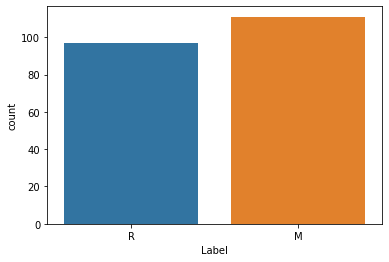

In [264]:
sns.countplot(data =df, x ='Label');

In [265]:
df['Target'] = df['Label'].map({'R':0,'M':1})

Наблюдается высокая степень автокорреляции, при которой каждая отдельная частота демонстрирует идеальную корреляцию с самой собой (коэффициент корреляции равен 1). Также, выявляется сильная положительная корреляция между соседними частотами в последовательности или ряду.

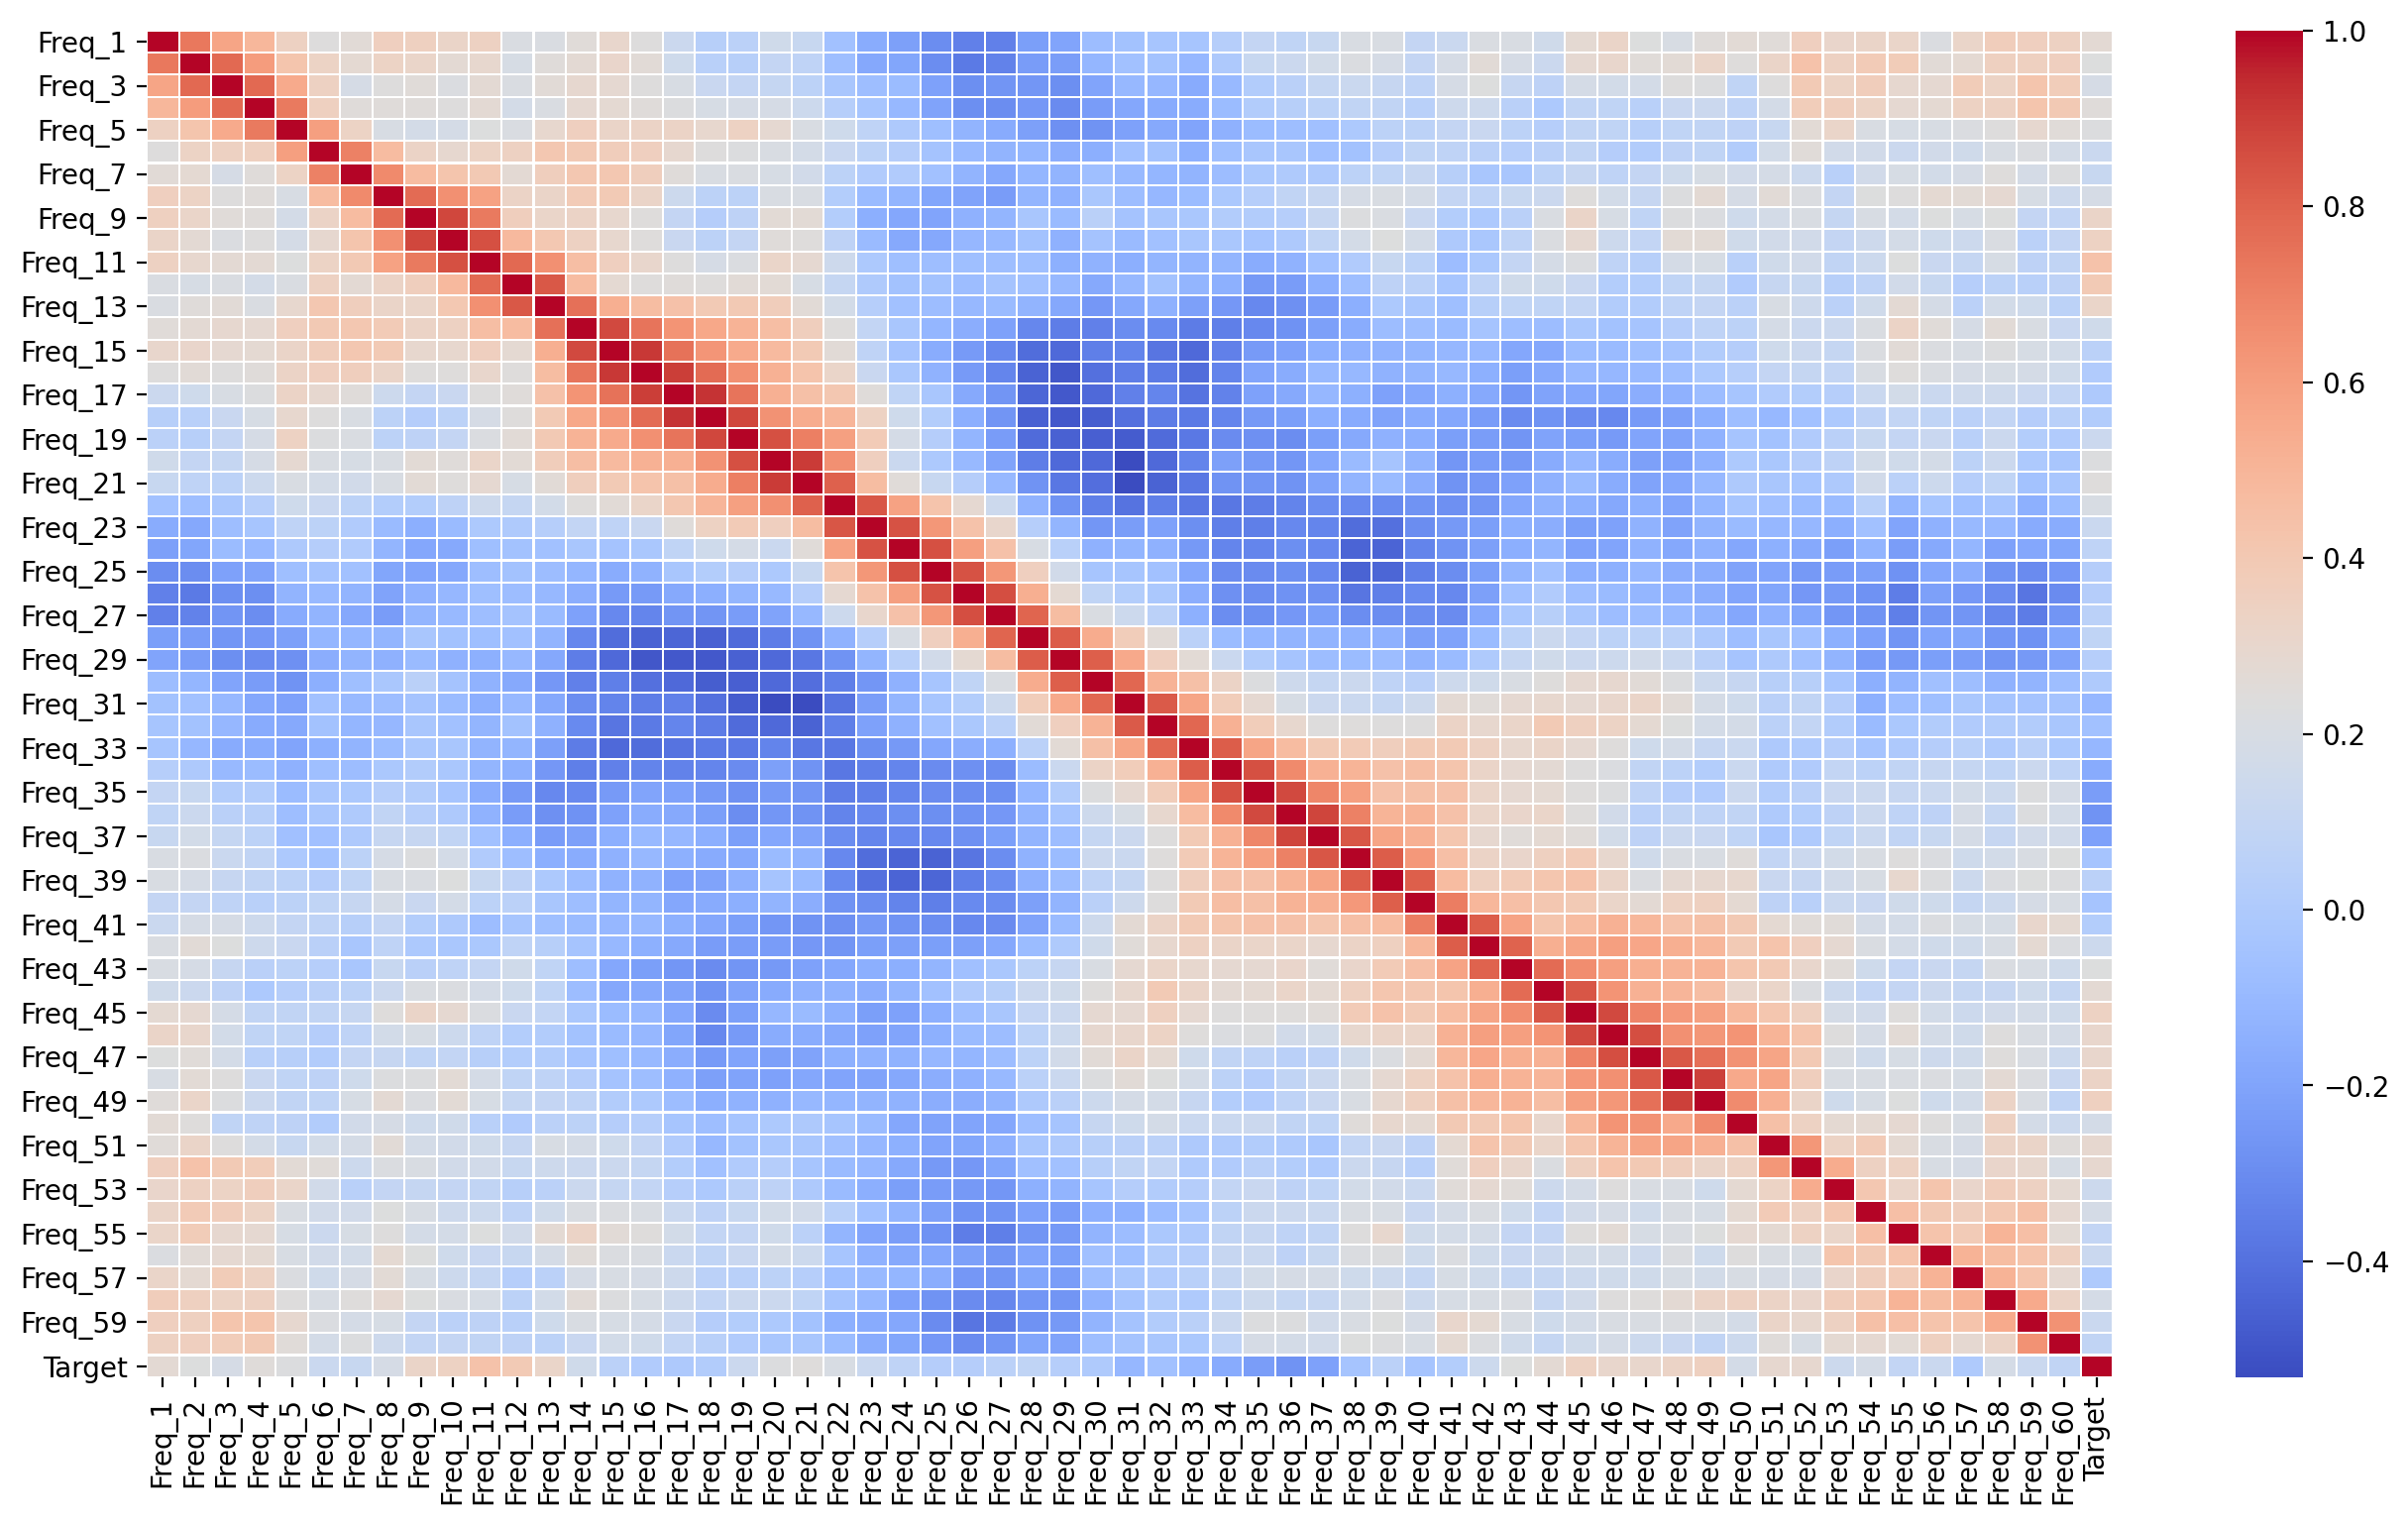

In [266]:
plt.figure(figsize=(16, 9), dpi=200)
sns.heatmap(df.corr(), cmap = 'coolwarm', linewidths = .4);

10 признаков, демонстрирующих самую высокую степень корреляции с целевой переменной, на основе абсолютного значения коэффициента корреляции. 

In [267]:
np.abs(df.corr()['Target']).sort_values().tail(11)

Freq_47    0.301697
Freq_46    0.305610
Freq_13    0.312811
Freq_9     0.321448
Freq_48    0.329333
Freq_45    0.339406
Freq_10    0.341142
Freq_49    0.351312
Freq_12    0.392245
Freq_11    0.432855
Target     1.000000
Name: Target, dtype: float64

### Model Initialization and Training

Разделение данных на признаки и целевую переменную.

In [268]:
X = df.drop(['Target','Label'],axis=1)
y = df['Label']

Разделение данных на обучающий и тестовый наборы. Размер тестовых данных составляет 10%.

In [269]:
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Создание конвейера обработки данных.

Для оптимизации процесса моделирования создан объект Pipeline. Этот конвейер последовательно выполняет две операции:

1. Масштабирование данных: На первом этапе применен StandardScaler для стандартизации признаков, что является критически важным шагом для алгоритмов, чувствительных к масштабу данных, таких как KNN.

2. Обучение модели: После масштабирования данных, на втором этапе произведена тренировка модели KNeighborsClassifier.

In [270]:
scaler = StandardScaler()
knn = KNeighborsClassifier()

operations = [('scaler',scaler),('knn',knn)]
pipe = Pipeline(operations)

k_values = list(range(1,30))
param_grid = {'knn__n_neighbors': k_values}

# Поиск оптимальных гиперпараметров с помощью кросс-валидации
full_cv_classifier = GridSearchCV(pipe,param_grid,cv=5,scoring='accuracy')
full_cv_classifier.fit(X_cv,y_cv)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29]},
             scoring='accuracy')

Словарь параметров лучшей модели, найденной в результате работы GridSearchCV.

In [271]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=1))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=1),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 1,
 'knn__p': 2,
 'knn__weights': 'uniform'}

С ростом числа k ошибка Error = 1- Accuracy возрастает, следовательно k=1 является наилучшим значением.

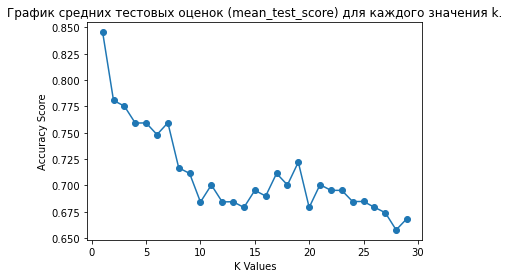

In [272]:
df_params = pd.DataFrame(full_cv_classifier.cv_results_)

scores = full_cv_classifier.cv_results_['mean_test_score']
plt.plot(k_values,df_params['mean_test_score'],'o-')
plt.title('График средних тестовых оценок (mean_test_score) для каждого значения k.')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score");

### Evaluation Metrics

In [273]:
y_pred = full_cv_classifier.predict(X_test)

Две точки классифицируются неверно.

In [274]:
confusion_matrix(y_test,y_pred)

array([[12,  1],
       [ 1,  7]], dtype=int64)

In [275]:
print(classification_report(y_test,full_pred))

              precision    recall  f1-score   support

           M       0.92      0.92      0.92        13
           R       0.88      0.88      0.88         8

    accuracy                           0.90        21
   macro avg       0.90      0.90      0.90        21
weighted avg       0.90      0.90      0.90        21

